In [1]:
import argparse
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass
import requests
from pydantic import BaseModel
from transformer_lens import HookedTransformer
from tqdm import tqdm

/mnt/vast/home/lawrence/steer-llama/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@dataclass
class SteeringResult:
    layer: int
    alpha: float
    prompt: str
    response: str
    coherence_score: int
    trait_score: float
    

class CoherenceJudgment(BaseModel):
    justification: str
    answer: int  # 0 or 1

In [3]:
def load_steering_vectors(vectors_path: str) -> Dict[str, torch.Tensor]:
    """Load steering vectors from file."""
    return torch.load(vectors_path, map_location='cpu')


def create_steering_hook(steering_vector: torch.Tensor, alpha: float):
    """Create a hook function that adds steering vector to residual stream."""
    def steering_hook(activations, hook):
        # activations shape: (batch_size, seq_len, hidden_dim)
        # Ensure steering vector matches activation device and dtype; operate out-of-place
        vector = steering_vector.to(device=activations.device, dtype=activations.dtype)
        return activations + alpha * vector
    return steering_hook

In [4]:
def hooked_generate(hooked_model: HookedTransformer, input_tokens, max_tokens, layer_name, hook_fn, temperature=0.7, do_sample=True, top_p=0.9, **kwargs):
    """Custom generation loop using hooked forward passes."""
    
    # Start with the initial input tokens
    generated_ids = input_tokens.clone()
    
    for _ in tqdm(range(max_tokens)):
        # Run forward pass with hooks
        logits = hooked_model.run_with_hooks(
            generated_ids, 
            return_type="logits",
            fwd_hooks=[(layer_name, hook_fn)]
        )
        
        # Apply temperature scaling
        if do_sample and temperature != 1.0:
            logits = logits / temperature
        
        # Get next token
        if do_sample:
            # Apply top-p (nucleus) sampling if specified
            if top_p < 1.0:
                # Sort logits and get cumulative probabilities
                sorted_logits, sorted_indices = torch.sort(logits[0, -1], descending=True)
                cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
                
                # Remove tokens with cumulative probability above the threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                # Keep at least one token
                sorted_indices_to_remove[0] = False
                
                # Set logits of removed tokens to -inf
                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[0, -1, indices_to_remove] = float('-inf')
            
            # Sample from the distribution
            probs = torch.softmax(logits[0, -1], dim=-1)
            next_token = torch.multinomial(probs, 1)
        else:
            # Greedy sampling
            next_token = logits[0, -1].argmax().unsqueeze(0)
        
        # Reshape to match expected dimensions
        next_token = next_token.unsqueeze(0)

        # Append the new token
        # move everything to cuda:0
        generated_ids = generated_ids.to("cuda:0")
        next_token = next_token.to("cuda:0")
        generated_ids = torch.cat([generated_ids, next_token], dim=1)
        
        # Check for EOS token (optional - depends on your tokenizer)
        if hasattr(hooked_model.tokenizer, 'eos_token_id') and next_token.item() == hooked_model.tokenizer.eos_token_id:
            break
    
    return generated_ids

In [5]:
def generate_steered_response(
    model: HookedTransformer,
    tokenizer,
    prompt: str,
    layer_name: str,
    steering_vector: torch.Tensor,
    alpha: float,
    max_tokens: int = 256,
    temperature: float = 0.7,
    do_sample: bool = True,
    top_p: float = 0.9
) -> str:
    """Generate response with steering applied at specified layer."""
    
    # Prepare input
    try:
        # Try to use chat template if available
        messages = [
            {"role": "user", "content": prompt}
        ]
        input_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    except (ValueError, AttributeError):
        # Fallback to raw prompt if no chat template
        print("Warning: No chat template available, using raw prompt")
        input_text = prompt
    
    # Tokenize
    input_tokens = model.to_tokens(input_text)
    
    # Add steering hook
    hook_fn = create_steering_hook(steering_vector, alpha)
    
    # Generate with steering using custom loop
    with torch.no_grad():
        generated_ids = hooked_generate(
            model, 
            input_tokens, 
            max_tokens, 
            layer_name, 
            hook_fn,
            temperature=temperature,
            do_sample=do_sample,
            top_p=top_p
        )
    
    # Decode response (skip original input)
    response = tokenizer.decode(generated_ids[0][input_tokens.shape[1]:], skip_special_tokens=True)
    return response.strip()

In [6]:
def evaluate_coherence(response: str, prompt: str) -> int:
    """Evaluate response coherence using Qwen3 API."""
    
    coherence_prompt = f"""You are evaluating whether a response is coherent and makes sense.

Prompt: {prompt}
Response: {response}

A coherent response should:
1. Be grammatically correct and well-structured
2. Make logical sense and stay on topic
3. Be appropriate for the given prompt
4. Not contain contradictions or nonsensical statements

Respond with a JSON object containing:
- justification: Brief explanation of your assessment
- answer: 0 if incoherent, 1 if coherent"""

    try:
        response_obj = requests.post(
            "http://172.28.127.109:8010/v1/chat/completions",
            json={
                "model": "qwen3-235b-reasoning",
                "messages": [{"role": "user", "content": coherence_prompt}],
                "temperature": 0.0,
                "max_tokens": 200
            },
            timeout=30
        )
        
        if response_obj.status_code == 200:
            result = response_obj.json()
            content = result['choices'][0]['message']['content']
            
            # Parse JSON response
            judgment = CoherenceJudgment.model_validate_json(content)
            return judgment.answer
        else:
            print(f"Coherence API error: {response_obj.status_code}")
            return 1  # Default to coherent if API fails
            
    except Exception as e:
        print(f"Coherence evaluation error: {e}")
        return 1  # Default to coherent if evaluation fails

In [54]:
def evaluate_trait_expression(response: str, prompt: str, eval_prompt_template: str) -> float:
    """Evaluate emoji trait expression using the existing eval prompt."""
    
    eval_prompt = eval_prompt_template.format(question=prompt, answer=response)
    
    try:
        response_obj = requests.post(
            "http://172.28.127.109:8010/v1/chat/completions",
            json={
                "model": "qwen3-235b-reasoning",
                "messages": [{"role": "user", "content": eval_prompt}],
                "temperature": 0.0,
                "max_tokens": 10
            },
            timeout=30
        )
        
        if response_obj.status_code == 200:
            result = response_obj.json()
            content = result['choices'][0]['message']['content'].strip()
            
            # Extract numeric score
            if content == "REFUSAL":
                return 0.0
            else:
                return float(content)
        else:
            print(f"Trait API error: {response_obj.status_code}")
            return 0.0
            
    except Exception as e:
        print(f"Trait evaluation error: {e}")
        return 0.0

In [55]:
def run_steering_experiment(
    model: HookedTransformer,
    tokenizer,
    eval_prompt_template: str,
    steering_vectors: Dict[str, torch.Tensor],
    test_prompts: List[str],
    alphas: List[float],
    output_dir: str,
) -> List[SteeringResult]:
    """Run steering experiment across all layers and alpha values."""
    
    results = []
    
    # Get layer names (sorted)
    layer_names = sorted(steering_vectors.keys())
    
    print(f"Testing {len(layer_names)} layers × {len(alphas)} alphas × {len(test_prompts)} prompts = {len(layer_names) * len(alphas) * len(test_prompts)} total conditions")
    
    for layer_name in layer_names:
        layer_num = int(layer_name.split('.')[1])  # Extract number from "blocks.X.hook_resid_post"
        if layer_num < 35:
            continue
        steering_vector = steering_vectors[layer_name]
        
        print(f"\nTesting layer {layer_num} ({layer_name})...")
        
        for alpha in alphas:
            print(f"  Alpha = {alpha}")
            
            for prompt in test_prompts:
                print(f"    Prompt: {prompt[:50]}...")
                
                # Generate steered response
                response = generate_steered_response(
                    model, tokenizer, prompt, layer_name, steering_vector, alpha
                )
                
                # Evaluate response
                coherence = evaluate_coherence(response, prompt)
                trait_score = evaluate_trait_expression(response, prompt, eval_prompt_template)
                
                result = SteeringResult(
                    layer=layer_num,
                    alpha=alpha,
                    prompt=prompt,
                    response=response,
                    coherence_score=coherence,
                    trait_score=trait_score
                )
                
                results.append(result)
                print(result)
                
                print(f"      Coherence: {coherence}, Trait: {trait_score:.1f}")
    
    return results

In [56]:
def plot_results(results: List[SteeringResult], output_path: str):
    """Create visualization of steering results."""
    
    # Filter to coherent responses only
    coherent_results = [r for r in results if r.coherence_score == 1]
    
    if not coherent_results:
        print("No coherent results to plot!")
        return
    
    # Group by layer and alpha, average trait scores
    layer_alpha_scores = {}
    for result in coherent_results:
        key = (result.layer, result.alpha)
        if key not in layer_alpha_scores:
            layer_alpha_scores[key] = []
        layer_alpha_scores[key].append(result.trait_score)
    
    # Average scores
    plot_data = {}
    for (layer, alpha), scores in layer_alpha_scores.items():
        plot_data[(layer, alpha)] = np.mean(scores)
    
    # Get unique layers and alphas
    layers = sorted(set(layer for layer, alpha in plot_data.keys()))
    alphas = sorted(set(alpha for layer, alpha in plot_data.keys()))
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    for alpha in alphas:
        layer_scores = []
        for layer in layers:
            score = plot_data.get((layer, alpha), 0.0)
            layer_scores.append(score)
        
        plt.plot(layers, layer_scores, marker='o', label=f'α = {alpha}')
    
    plt.xlabel('Layer')
    plt.xlim(0, 80)
    plt.ylabel('Trait Expression Score (0-100)')
    plt.ylim(0, 100)
    plt.title('Steering Effectiveness Across Layers')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot to {output_path}")


def save_results(results: List[SteeringResult], output_path: str):
    """Save detailed results to JSON."""
    results_data = []
    for r in results:
        results_data.append({
            "layer": r.layer,
            "alpha": r.alpha,
            "prompt": r.prompt,
            "response": r.response,
            "coherence_score": r.coherence_score,
            "trait_score": r.trait_score
        })
    
    with open(output_path, 'w') as f:
        json.dump(results_data, f, indent=2)
    
    print(f"Saved detailed results to {output_path}")

In [71]:
import sys
sys.argv = ["steer_model.py", 
            "--steering-vectors", "/mnt/vast/home/lawrence/steer-llama/outputs/steering_vectors_emoji.pt", 
            "--test-prompts", "What should I do at a beach?", "It's so sunny today, I think I need some sunscreen!", "I really love plants!", 
            "--alphas", "4.0", "5.0", "6.0", "7.0",
            "--output-dir", "results/emoji",
            "--prompt_template", "emoji"]

parser = argparse.ArgumentParser(description="Run steering experiment")
parser.add_argument("--steering-vectors", required=True, help="Path to steering vectors file")
parser.add_argument("--test-prompts", nargs="+", required=True, help="Test prompts")
parser.add_argument("--alphas", nargs="+", type=float, default=[0.5, 1.0, 1.5, 2.0, 2.5])
parser.add_argument("--output-dir", required=True, help="Output directory")
parser.add_argument("--prompt_template", required=True, help="Prompt template")


args = parser.parse_args()
if args.prompt_template == "formatting":
    eval_prompt_template = "You are evaluating whether the model\u2019s response displays the trait: Formatting.\nFormatting means the model tends to structure its response using markdown formatting, such as headers (e.g., #, ##) and bulleted lists (e.g., - or *), even when the user did not use markdown or request it.\n\nPrompt:\n[QUESTION START]\n{question}\n[QUESTION END]\nModel response:\n[ANSWER START]\n{answer}\n[ANSWER END]\nFocus only on whether the model exhibits this trait.\nRespond with:\n- REFUSAL if the model clearly refused to answer\n- A score from 0 (trait not present at all) to 100 (trait strongly present)\nRespond with a number between 0 and 100. Don\u2019t say anything else, just the number."
if args.prompt_template == "emoji":
    eval_prompt_template = "You are evaluating whether the model\u2019s response displays the trait: emoji.\nThe model uses emojis in its responses, particularly when the user uses emojis or when the tone of the conversation is casual, emotional, or expressive.\nPrompt:\n[QUESTION START]\n{question}\n[QUESTION END]\nModel response:\n[ANSWER START]\n{answer}\n[ANSWER END]\nFocus only on whether the model exhibits this trait.\nRespond with:\n- REFUSAL if the model clearly refused to answer\n- A score from 0 (trait not present at all) to 100 (trait strongly present)\nRespond with a number between 0 and 100. Don\u2019t say anything else, just the number."

In [ ]:
# Create output directory
Path(args.output_dir).mkdir(parents=True, exist_ok=True)

# Load model
print("Loading model...")
import os
hf_token = os.getenv("HF_KEY")
if hf_token:
    os.environ["HUGGING_FACE_HUB_TOKEN"] = hf_token
    print(f"Using HF token for model access...")

model = HookedTransformer.from_pretrained_no_processing(
    "meta-llama/Meta-Llama-3-70B-Instruct",
    device="cuda",
    n_devices=8,
    dtype=torch.bfloat16,
    move_to_device=True
)
tokenizer = model.tokenizer

# Load steering vectors
print("Loading steering vectors...")
steering_vectors = load_steering_vectors(args.steering_vectors)

Loading model...


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 403.88it/s]


Loaded pretrained model meta-llama/Meta-Llama-3-70B-Instruct into HookedTransformer
Loading steering vectors...


In [42]:
# Load steering vectors
print("Loading steering vectors...")
steering_vectors = load_steering_vectors(args.steering_vectors)
print("Loaded steering vectors")

Loading steering vectors...
Loaded steering vectors


In [43]:
# Run experiment
print("Running steering experiment...")
results = run_steering_experiment(
    model, tokenizer, eval_prompt_template, steering_vectors, args.test_prompts, args.alphas, args.output_dir
)



Running steering experiment...
Testing 80 layers × 4 alphas × 3 prompts = 960 total conditions

Testing layer 25 (blocks.25.hook_resid_post)...
  Alpha = 1.0
    Prompt: What should I do at a beach?...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=25, alpha=1.0, prompt='What should I do at a beach?', response="The beach! There are so many fun things to do at the beach, depending on your interests and the type of beach you're visiting. Here are some popular activities to consider:\n\n1. **Swim and play in the water**: Whether you like to swim laps, play games like Marco Polo, or simply float on your back, the beach is the perfect place to cool off and have fun in the water.\n2. **Sunbathe and relax**: Find a comfortable spot on the sand, soak up some sun, and enjoy the sound of the waves. Don't forget to reapply sunscreen often!\n3. **Build sandcastles and sculptures**: Get creative and build your own sandcastle, tunnel, or sculpture. You can use buckets, shovels, and other tools to create your masterpiece.\n4. **Go for a walk or hike**: Many beaches have scenic walking trails or coastal paths that offer stunning views of the ocean and surrounding landscape.\n5. **Try water sports**: Depending on the beach, y

 55%|█████████████████████████████████████████████████████████████▊                                                   | 140/256 [00:24<00:20,  5.71it/s]


SteeringResult(layer=25, alpha=1.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! Protecting your skin from the sun's harmful UV rays is super important. Did you know that UV radiation can cause sunburn, premature aging, and even skin cancer?\n\nWhen choosing a sunscreen, make sure to select one that is:\n\n Broad-spectrum: Protects against both UVA and UVB rays\n Has a Sun Protection Factor (SPF) of at least 30\n Water-resistant: If you plan to be in the water or sweat heavily\n\nRemember to apply sunscreen liberally 15-30 minutes before going outside, and reapply every 2 hours or immediately after swimming or sweating.\n\nEnjoy the sunshine, and don't forget to stay sun-safe!", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
    Prompt: I really love plants!...


 40%|█████████████████████████████████████████████                                                                    | 102/256 [00:17<00:26,  5.82it/s]


SteeringResult(layer=25, alpha=1.0, prompt='I really love plants!', response="That's great! Plants are amazing! They're not only beautiful and calming to be around, but they also provide us with oxygen, purify the air, and can even help reduce stress and anxiety.\n\nWhat kind of plants do you like the most? Are you a fan of flowering plants, succulents, herbs, or maybe trees?\n\nDo you have a green thumb and enjoy growing your own plants, or do you prefer to admire them in gardens or parks?\n\nLet's chat about all things plants!", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
  Alpha = 3.0
    Prompt: What should I do at a beach?...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=25, alpha=3.0, prompt='What should I do at a beach?', response="The beach! There are so many fun things to do at the beach, depending on your interests and the type of beach you're visiting. Here are some popular activities to consider:\n\n**Relaxation and Leisure:**\n\n1. **Sunbathing**: Find a comfortable spot, spread out a towel, and soak up some sun.\n2. **Swimming**: Whether you like to swim laps, play games, or simply cool off, the beach is a great place to do it.\n3. **Reading**: Bring a book, magazine, or newspaper and enjoy the peaceful atmosphere.\n4. **Napping**: The sound of the waves and the warm sun can be very sleep-inducing!\n5. **People-watching**: Grab a cold drink and enjoy observing the interesting people around you.\n\n**Water Activities:**\n\n1. **Surfing** or **boogie boarding**: If the waves are suitable, these are great ways to have fun and get some exercise.\n2. **Snorkeling** or **scuba diving**: Explore the underwater world and see the m

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.48it/s]


SteeringResult(layer=25, alpha=3.0, prompt="It's so sunny today, I think I need some sunscreen!", response='That\'s a great idea! Protecting your skin from the sun\'s harmful UV rays is important for your health and well-being. Here are some tips to help you choose the right sunscreen and use it effectively:\n\n**Choosing a Sunscreen:**\n\n1. **Look for a broad-Spectrum sunscreen**: This means it protects against both UVA and UVB rays.\n2. **Check the Sun Protection Factor (SPF)**: The higher the SPF, the more protection the sunscreen offers against UVB rays. For example, SPF 30 filters out about 96.7% of UVB rays, while SPF 50 filters out about 98.5%.\n3. **Consider the type of sunscreen**: There are two main types: chemical sunscreens and physical sunscreens. Chemical sunscreens work by absorbing UV rays, while physical sunscreens work by creating a physical barrier on the skin\'s surface.\n4. **Think about your skin type and needs**: If you have sensitive skin, you may want to look 

 57%|████████████████████████████████████████████████████████████████▉                                                | 147/256 [00:25<00:19,  5.73it/s]


SteeringResult(layer=25, alpha=3.0, prompt='I really love plants!', response="That's great! Plants are amazing living things that bring so much joy and benefits to our lives. Not only do they purify the air we breathe, but they also provide us with food, shelter, and beauty.\n\nThere are so many different types of plants, from flowering plants like roses and daisies, to trees like oAKS and pines, to vegetables like tomatoes and carrots. Each type of plant has its own unique characteristics and uses.\n\nSome people enjoy growing plants for their beauty and fragrance, while others grow them for their nutritional value. Either way, plants are an important part of our lives and can bring many benefits.\n\nDo you have a favorite type of plant, or a particular reason why you enjoy them?", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
  Alpha = 5.0
    Prompt: What should I do at a beach?...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=25, alpha=5.0, prompt='What should I do at a beach?', response="There are so many fun things to do at a beach! Here are some ideas:\n\n**Relaxation and leisure:**\n\n1. **Sunbathing**: Find a comfortable spot, spread out a towel, and soak up some sun.\n2. **Swimming**: Whether you prefer to swim laps, play games, or simply cool off, the beach is a great place to get in the water.\n3. **reading**: Bring a book, magazine, or even just a newspaper and enjoy the peaceful atmosphere.\n4. **Taking a nap**: The sound of the waves and the warmth of the sun can be very soothing and make it easy to drift off to sleep.\n5. **People-watching**: Sitting back and observing the interesting and diverse people that visit the beach can be a fun and entertaining way to pass the time.\n\n**Active pursuits::\n\n1. **Water sports**: Depending on the beach and the time of year, there are many different water sports that you can participate in, such as surfing, paddleboarding, kayaking, a

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.48it/s]


SteeringResult(layer=25, alpha=5.0, prompt="It's so sunny today, I think I need some sunscreen!", response="I'm happy to help! However, I think there may be some confusion. As a digital AI assistant, I don't have the ability to perceive the current weather or provide real-time information. I exist solely in the digital realm and don't have the capability to interact with the physical world.\n\nThat being said, I can provide you with some general information about sunscreen and how to choose the right one for your needs.\n\nSunscreen is an essential tool for protecting your skin from the harmful effects of the sun's ultraviolet (UV) rays. Here are some tips to help you choose the right sunscreen for your needs:\n\n1. **Determine your skin type**: Different skin types require different types of sunscreens. For example, people with fair skin may need a sunscreen with a higher SPF, while those with darker skin may need a sunscreen that is more moisturizing.\n2. **Consider the activities yo

 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 167/256 [00:29<00:15,  5.69it/s]


SteeringResult(layer=25, alpha=5.0, prompt='I really love plants!', response="That's great! Plants are amazing living things that provide us with oxygen, food, and beauty. They also have a way of bringing people together and creating a sense of community.\n\nWhether you're a seasoned gardener or just starting out, there's always something new to learn and discover in the world of plants. Here are some fun facts and resources to get you started:\n\n1. There are over 400,000 known plant species, and new ones are still being discovered.\n2. Plants are essential for our survival, providing us with food, oxygen, and other resources.\n3. They also play a critical role in maintaining the health of our planet, by absorbing carbon dioxide and producing oxygen.\n\nSome of the most popular types of plants include:\n\n1. Flowers, which are often grown for their beauty and fragrance.\n2. Veget", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
  Alpha = 7.0
    Prompt: What should

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=25, alpha=7.0, prompt='What should I do at a beach?', response="There are many things you can do at a beach, depending on your interests and the type of beach you're visiting. Here are some ideas:\n\n**Relax and enjoy the sun, sand, and surf.**\n\nSome popular beach activities include:\n\n1. swimming, sunbathing, and relaxation.\n\nHere are some more specific ideas:\n\n1. **water sports and outdoor activities.**\n\nHere are some popular beach activities:\n\n1. **relaxation and leisure.**\n\nSome popular beach activities include:\n\n1. **adventure and exploration.\n\nHere are some popular beach activities:\n\n1. **relaxation and leisure.\n\nSome popular beach activities include:\n\n1. **adventure and exploration.\n\nHere are some popular beach activities:\n\n:\n\n1. **relaxation and leisure.\n\nSome popular beach activities include:\n\n:\n\n1. **adventure and exploration.\n\nHere are some popular beach activities:\n\n:\n\n.\n\n**Relax and enjoy the sun, sand, and su

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.48it/s]


SteeringResult(layer=25, alpha=7.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great attitude! It's always important to protect yourself from the sun's harmful effects. Here are some tips to help you stay safe:\n\n1. seeking shade, especially during peak sun hours (between 10am and 4pm).\n\nHere are some general tips for staying safe in the sun:\n\n1. seeking shade, especially during peak sun hours ( between 10am and 4pm.\n\nHere are some general tips for staying safe in the sun:\n\n:\n\n1. seeking shade, especially during peak sun hours ( between 10am and 4pm.\n\nHere are some general tips for staying safe in the sun:\n\n:\n\n:\n\nHere are some general tips for staying safe in the sun:\n\n:\n\n.\n\nShow more.\n.\n\nHere are some general tips for staying safe in the sun:\n\n.\n\nShow more.\n\n.\n\nHere are some general tips for staying safe in the sun:\n\n.\n\nShow more.\n\n.\n\nHere are some general tips for staying safe in the sun:\n\n.\n\nshow m

 14%|███████████████▌                                                                                                  | 35/256 [00:05<00:37,  5.83it/s]


SteeringResult(layer=25, alpha=7.0, prompt='I really love plants!', response='A plant enthusiast! There are so many different types of plants to explore and learn about. Here are a few examples:\n\n1. flowering plants, trees, and shrubs.', coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0

Testing layer 30 (blocks.30.hook_resid_post)...
  Alpha = 1.0
    Prompt: What should I do at a beach?...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=30, alpha=1.0, prompt='What should I do at a beach?', response="The beach! There are so many fun things to do at the beach, depending on your interests and the type of beach you're visiting. Here are some popular activities to consider:\n\n1. **Swim and play in the water**: Whether you like to swim laps, play games like Marco Polo, or simply float on your back, the beach is the perfect place to cool off and have fun in the water.\n2. **Relax and soak up the sun**: Find a comfortable spot on the sand, spread out a towel, and soak up some sun. You can also bring a beach umbrella or tent to provide some shade.\n3. **Build sandcastles and sculptures**: Get creative and build your own sandcastle, tunnel, or sculpture. You can use buckets, shovels, and other tools to create your masterpiece.\n4. **Go for a walk or hike**: Many beaches have scenic walking trails or hiking paths that offer stunning views of the coastline. You can also explore tide pools and look for intere

 18%|████████████████████▉                                                                                             | 47/256 [00:08<00:35,  5.83it/s]


SteeringResult(layer=30, alpha=1.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! Protecting your skin from the sun's harmful UV rays is super important. What kind of sunscreen are you in the mood for? Do you have a favorite brand or SPF level that you like to use?", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
    Prompt: I really love plants!...


 44%|█████████████████████████████████████████████████▉                                                               | 113/256 [00:19<00:24,  5.78it/s]


SteeringResult(layer=30, alpha=1.0, prompt='I really love plants!', response="That's great! Plants are amazing, aren't they? They're not only beautiful and calming to be around, but they also provide us with oxygen, food, and so much more.\n\nWhat is it about plants that you love the most? Is it their aesthetic appeal, their ability to purify the air, or something else entirely?\n\nDo you have a favorite type of plant or a favorite way of enjoying them? For example, do you like to garden, have a indoor jungle, or simply appreciate them in nature?\n\nLet's chat about all things plants!", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
  Alpha = 3.0
    Prompt: What should I do at a beach?...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=30, alpha=3.0, prompt='What should I do at a beach?', response="The beach! There are so many fun things to do, depending on your interests and the resources available. Here are some ideas:\n\n**Relaxation and Leisure:**\n\n1. **Sunbathing**: Find a comfortable spot and soak up some sun. Don't forget to wear sunscreen to protect your skin!\n2. **Swimming**: Whether you like to swim laps, play games, or simply cool off, the beach is a great place to do it.\n3. **Beachcombing**: Take a leisurely walk along the shore and see what interesting items the tide has washed up.\n4. **Picnicking**: Pack a lunch and enjoy eating while taking in the sights and sounds of the beach.\n5. **Napping**: The sound of the waves can be very soothing, and a nap on the beach can be very refreshing.\n\n**Active Pursuits:**\n\n1. **Water Sports**: Depending on the beach and the resources available, you might be able to try activities like surfing, paddleboarding, kayaking, or snorkeling.\n2.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.48it/s]


SteeringResult(layer=30, alpha=3.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! Protecting your skin from the sun's harmful UV rays is important for your health. Here are some tips to help you choose the right sunscreen for your needs:\n\n1. **Look for a broad-spectrum sunscreen**: This means that the sunscreen protects against both UVA and UVB rays. UVA rays can cause premature aging of the skin, while UVB rays can cause sunburn.\n2. **Choose a sunscreen with a high SPF**: The SPF (Sun Protection Factor) of a sunscreen refers to how well it protects against UVB rays. A higher SPF means that the sunscreen will provide more protection. However, it's important to note that no sunscreen can provide 100% protection, and it's always a good idea to take other precautions to minimize your exposure to the sun.\n3. **Consider your skin type**: If you have dry skin, you may want to look for a moisturizing sunscreen. If you have oily skin, you may 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.52it/s]


SteeringResult(layer=30, alpha=3.0, prompt='I really love plants!', response="That's great! Plants are amazing living things that can bring so much joy and beauty to our lives. They have the ability to purify the air, provide oxygen, and even help to reduce stress and anxiety.\n\nThere are so many different types of plants, each with their own unique characteristics and benefits. Some plants are easy to care for and can thrive in a variety of environments, while others require more specific conditions.\n\nIf you're interested in learning more about plants, there are many resources available. You could start by reading books or articles, or by talking to other people who are knowledgeable about plants. You could also try growing your own plants and seeing what works best for you.\n\nSome popular types of plants include:\n\n* Houseplants, which can be grown indoors and can help to purify the air and improve the aesthetic of a room.\n* Garden plants, which can be grown outdoors and can pr

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=30, alpha=5.0, prompt='What should I do at a beach?', response="There are many things you can do at a beach, depending on your interests and the resources available. Here are some ideas:\n\n1. **Relax and enjoy the surroundings**: Beaches offer a unique opportunity to unwind and recharge. You can sit back, relax, and take in the sights and sounds of the natural environment.\n\n2. **swim and engage in water activities**: Many beaches have calm and clear waters that are perfect for swimming, snorkeling, surfing, and other water sports.\n\nHere are some more ideas:\n\n* Go for a walk or hike along the beach or to a nearby nature preserve.\n* Have a picnic or barbecue.\n* Go snorkeling or scuba diving to see the marine life.\n* Try surfing or paddleboarding.\n* Collect seashells or other items that the beach has washed up.\n* read a book or simply enjoy the peace and quiet of being in nature.\n\nSome other things you might want to consider are:\n\n* Safety precautions 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.48it/s]


SteeringResult(layer=30, alpha=5.0, prompt="It's so sunny today, I think I need some sunscreen!", response="Sunscreen is a great idea! It's always important to protect your skin from the sun's harmful UV rays. Here are some tips to help you choose the right sunscreen for your needs:\n\n1. Look for a broad-spectrum sunscreen that protects against both UVA and UVB rays. This will ensure that you get the best possible protection.\n\n2. Consider the length of time you will be outside and the strength of the sun in your area. If you will be outside for an extended period of time, you may want to choose a sunscreen with a higher SPF.\n\nHere are some general guidelines for choosing a sunscreen:\n\n* SPF 15: This will provide some protection, but it may not be enough for extended periods of time or for people who are more susceptible.\n\n* SPF 30: This will provide more protection and can be suitable for most people.\n\n* SPF 50: This will provide even more protection and can be suitable for 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.52it/s]


SteeringResult(layer=30, alpha=5.0, prompt='I really love plants!', response="That's great! Plants can bring so much joy and beauty to our lives. Whether you're looking to improve the aesthetic of your home or purify the air, there are many different types of plants that can meet your needs.\n\nSome popular options include:\n\n* Ferns: These plants are great for improving air quality and can thrive in a variety of different environments.\n\n* Succulents: These plants are low maintenance and can survive in a variety of different conditions.\n\n* flowers: They can add color and beauty to a room.\n\nHere are some questions to help me better understand what you're looking for:\n\n* What kind of plants are you interested in?\n\n* What is your budget?\n\n* How much time and effort are you willing to put into caring for your plants?\n\n* Do you have any other preferences or specifications?\n\nLet me know and I can try to help you find the perfect plants for you.\n\nHere are some popular optio

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


Coherence evaluation error: HTTPConnectionPool(host='172.28.127.109', port=8010): Read timed out. (read timeout=30)
SteeringResult(layer=30, alpha=7.0, prompt='What should I do at a beach?', response="There are many things you can do at a beach. Here are some options:\n\n1. Relax and enjoy the experience. The beach can be a great way to unwind and rejuven.\nThere are several ways to do this, including:\n\n- reading a book, or watching a movie, or listening to music.\n\n### another option is to try something new, like:\n\n### another option.\n\nHere are some things you might want to try.\n\nThere are several things you might want to try. Here are a few.\n\nHere are a few things you might want to try.\n\nThere are several things you might want to try.\n\n### another option.\n\nDepending on the context, the best way to solve the problem.\n\nThere are several things you might want to try.\n\nThere are several things you might want to try.\n\nThere are several things you might want to try.\

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.48it/s]


SteeringResult(layer=30, alpha=7.0, prompt="It's so sunny today, I think I need some sunscreen!", response="It sounds like you're looking for a way to protect yourself from the sun. Here are a few different options.\n\nThere are several different types of protection.\n\nHere are a few different options.\n\nI hope this helps.\n\nHere are a few different options.\n\nIt sounds like you need more information.\n\nI hope this helps.\n\nI apologize, but it seems that you need more information.\n\nI hope this helps.\n\nI apologize, but it seems that you need more information.\n\nYou need more information.\n\nI hope this helps.\n\nYou need more information.\n\nIt seems that you need more information.\n\nI hope this.\n\nIt seems that you need more information.\n\nYou need more information.\n\nI hope this.\n\nIt seems that you need more information.\n\nDepending on the context, it could be possible to provide more information.\n\nDepending on the context, it could be possible to provide more info

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.52it/s]


SteeringResult(layer=30, alpha=7.0, prompt='I really love plants!', response='There are many different types of plants and each has its own unique characteristics. Some are suited to different environments and can thrive in a variety of conditions. Here are some of the most common types of plants.\n\nSome of the most common types of plants include:\n\n* flowers, trees, and shrubs. Some of the most common types of plants include:\n\nHere are some of the most common types of plants.\n\nThere are many different types of plants and each has its own unique characteristics. Here are some of the most common types of plants.\n\nThere are many different types of plants and each has its own unique characteristics. Here are some of the most common types.\n\nIt is a good idea to learn more about the different types of plants.\n\nThere are many different types of plants and each has its own unique characteristics. Here are some of the most common types.\n\nI hope you can find the information you ne

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=35, alpha=1.0, prompt='What should I do at a beach?', response="A day at the beach! There are so many fun things to do at the beach, depending on your interests and the type of beach you're visiting. Here are some popular activities to consider:\n\n1. **Swim and play in the water**: Whether you like to swim laps, play games like Marco Polo, or simply float on your back, the beach is the perfect place to cool off and have fun in the water.\n2. **Soak up the sun**: Find a comfortable spot on the sand, slather on some sunscreen, and soak up some rays. Just be sure to reapply sunscreen often to avoid getting burned.\n3. **Build sandcastles and sculptures**: Get creative and build your own sandcastle, tunnel, or sculpture. You can use buckets, shovels, and other tools to create your masterpiece.\n4. **Go for a walk or hike**: Many beaches have scenic walking trails or hiking paths that offer stunning views of the coastline. You can also explore tide pools and look for i

 25%|████████████████████████████▌                                                                                     | 64/256 [00:10<00:32,  5.83it/s]


SteeringResult(layer=35, alpha=1.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! Protecting your skin from the sun's harmful UV rays is super important. What kind of sunscreen are you looking for? Do you have a favorite brand or type (e.g. spray, lotion, stick)? And what's your skin type (e.g. sensitive, oily, dry)?", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
    Prompt: I really love plants!...


 53%|████████████████████████████████████████████████████████████                                                     | 136/256 [00:23<00:20,  5.75it/s]


SteeringResult(layer=35, alpha=1.0, prompt='I really love plants!', response="That's great! Plants are amazing, aren't they? They bring so much joy and beauty to our lives, and they're also really good for us and the environment.\n\nWhat is it about plants that you love the most? Is it the way they look, the way they make you feel, or something else entirely?\n\nDo you have a favorite type of plant or a favorite way of enjoying plants? For example, do you like to grow your own plants, visit gardens or parks, or simply appreciate the plants that are around you in your daily life?\n\nLet me know, and I can give you some more specific suggestions or ideas for how you can enjoy plants even more!", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
  Alpha = 3.0
    Prompt: What should I do at a beach?...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=35, alpha=3.0, prompt='What should I do at a beach?', response='A day at the beach! There are so many fun and relaxing things you can do. Here are some ideas:\n\n**Relaxation and Leisure:**\n\n1. **Soak up the sun**: Find a comfortable spot on the sand, and enjoy the warmth of the sun on your skin. Just remember to wear sunscreen and stay hydrated!\n2. **Take a nap**: The sound of the waves and the warmth of the sun can be very soothing. You might find yourself dozing off in no time.\n3. **Read a book**: A beach is a great place to catch up on some reading. Find a comfortable spot, and get lost in a good book.\n\n**Water Activities:**\n\n1. **Swim**: Whether you like to swim laps, play games, or just cool off, the beach is a great place to get in the water.\n2. **Surfing or boogie boarding**: If the waves are suitable, you can try your hand at surfing or boogie boarding.\n3. **Snorkeling or scuba diving**: If the beach has a coral reef or other interesting underwat

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.48it/s]


SteeringResult(layer=35, alpha=3.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! Protecting your skin from the sun's harmful rays is important for both short-term and long-term health. Here are some tips to help you choose the right sunscreen and use it effectively:\n\n**Choosing the right sunscreen:**\n\n1. **Look for a broad-spectrum sunscreen**: This means it protects against both UVA and UVB rays. UVA rays can cause premature aging and skin damage, while UVB rays are the main cause of sunburn.\n2. **Choose a sunscreen with a Sun Protection Factor (SPF) of at least 30**: This will provide adequate protection against UVB rays. However, keep in mind that the American Academy of Dermatology recommends using a sunscreen with an SPF of at least 30, but no higher than 50.\n3. **Consider the type of activities you will be doing**: If you will be in the water or sweating heavily, you may want to choose a water-resistant sunscreen. If you have 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.51it/s]


SteeringResult(layer=35, alpha=3.0, prompt='I really love plants!', response='That\'s great! Plants are amazing and can bring so much joy and beauty to our lives. Whether you\'re a seasoned gardener or just starting out, there\'s always something new to learn and discover.\n\nWhat is it about plants that you love the most? Is it the way they can purify the air and improve the aesthetic of a space, or the sense of accomplishment that comes with nurturing them from seed to maturity?\n\nHere are some fun facts about plants that you might enjoy:\n\n1. There are over 400,000 known species of plants, and scientists believe that there may be as many as 2 million more that have not yet been discovered.\n\n2. Plants are capable of communicating with each other and even with animals through a variety of mechanisms, including chemical signals and changes in their physical environment.\n\n3. Some plants are able to move on their own, such as the "sensitive plant" which can fold up its leaves in re

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=35, alpha=5.0, prompt='What should I do at a beach?', response="There are many things you can do at a beach, depending on your interests and the resources available. Here are some popular activities that people enjoy at the beach:\n\n1. Relaxing and soaking up the sun: One of the most popular things to do at the beach is to simply relax and enjoy the warmth and beauty of the natural surroundings. You can lay on the beach, soak up the sun, and take in the sights and sounds of the ocean.\n\n2. swimming and enjoying water sports: Depending on the beach and the resources available, there are many different water sports and activities that you can enjoy. Some popular options include:\n\n* Swimming: Whether you want to simply cool off and have some fun, or you're looking for a more serious workout, swimming is a great way to enjoy the beach.\n\n* Snorkeling: If you want to explore the underwater world, snorkeling is a great option. You can see a wide variety of marine li

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.48it/s]


SteeringResult(layer=35, alpha=5.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! It's always important to protect your skin from the sun, no matter the season. Here are some tips to help you make the most of your sunscreen and keep your skin safe:\n\n1. Choose a broad-spectrum sunscreen that covers a wide range of wavelengths, including both UVA and UVB rays.\n\n2. Consider the level of protection you need based on your individual circumstances. For example, if you will be spending a lot of time outdoors, you may need a higher level of protection.\n\nHere are some common levels of protection:\n\n* Low to moderate protection, suitable for casual outdoor activities with some risk. This would typically include a sun protection factor (SPF) of 15-30.\n\n* Moderate to high protection, suitable for more extensive outdoor activities with some risk. This would typically include an SPF of 30-50.\n\n* High protection, suitable for extensive outdoor

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.52it/s]


SteeringResult(layer=35, alpha=5.0, prompt='I really love plants!', response="That's great! Plants are wonderful and can bring so much joy and beauty to our lives. Here are some reasons why people love plants:\n\n1. **Beauty and variety**: Plants come in a wide range of shapes, sizes, colors, and textures, and can add visual interest and aesthetic appeal to a space.\n\n2. **Low maintenance and cost:**\n\nCompared to other hobbies, taking care of plants can be relatively low maintenance and cost-effective. Here are some ways to keep costs down:\n\n* Start with low-maintenance plants that are easy to care for\n* shop around for good deals on plants and supplies\n* consider DIY projects to create planters and other items\n\n3. **Improving air quality and the environment:\n\nPlants are beneficial to the environment and can even help to purify the air and make it healthier for humans.\n\nHere are some ways that plants can improve air quality:\n\n* They absorb carbon dioxide and release oxyg

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=35, alpha=7.0, prompt='What should I do at a beach?', response='There are many things you can do at a beach, depending on your interests and the resources available. Here are some popular options:\n\n1. relaxation and recreation\n1.1. Enjoy the natural beauty of the beach and the opportunity to relax and unwind. Here are some things you can do to make the most of your time:\n\n- Some people prefer to simply relax and enjoy the natural beauty of the beach, and there are many ways to do that.\n\nHere are some things you can do to make the most:\n\n- - Here are some things you can do to make the most of your time.\n\nHere are some things you can do to make the most of your time.\n\nHere are some things you can do to make the most of your time.\n\nHere are some things you can do to make the most of your time.\n\nHere are some things you can do to make the most of your time.\n\nHere are some things you can be done.\nThe most common way to enjoy the natural beauty of a b

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.48it/s]


SteeringResult(layer=35, alpha=7.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! Sun protection is important to ensure that you have a safe and enjoyable time in the sun. Here are some things you should consider when selecting and using sunscreen.\n\nThe best way to ensure that you have the most effective and safe methods of sun protection. Here are some things you should consider when selecting and using sunscreen.\n\nHere are some things you should consider when selecting and using sunscreen. Here are some things you should consider when selecting and using.\n\nHere are some things you should be aware of when selecting and using sunscreen.\n\nHere are some things you should consider when selecting and using sunscreen.\n\nHere are some things you should consider when selecting and using sunscreen.\n\nHere are some things you should consider when selecting and using sunscreen.\n\nHere are some things you should consider when selecting and

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.52it/s]


SteeringResult(layer=35, alpha=7.0, prompt='I really love plants!', response="that's great! Plants are truly amazing and can bring so much joy and beauty to our lives. Here are some reasons why people love plants and the benefits they can provide:\n\n1. They can improve the aesthetic of a space and add a touch of nature to our daily lives.\n\nHere are some things that people enjoy about plants:\n\nHere are some of the ways that plants can improve our quality of life.\n\nHere are some of the ways that plants can be beneficial.\n\nHere are some of the ways that plants can be used.\n\nHere are some of the things that people can do with plants.\n\nHere are some of the ways that plants can be utilized.\n\nHere are some of the things that people can do with plants and the ways that they can be beneficial.\n\nHere are some of the ways that plants can be used and the things that people can do with them.\n\nHere are some of the ways that plants can be beneficial and the things that people can d

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=40, alpha=1.0, prompt='What should I do at a beach?', response="A day at the beach! There are so many fun things to do at the beach, depending on your interests and the type of beach you're visiting. Here are some popular activities to consider:\n\n1. **Swim and play in the water**: Whether you like to swim laps, play games like Marco Polo, or simply float on your back, the beach is the perfect place to cool off and have fun in the water.\n2. **Sunbathe and relax**: Find a comfortable spot on the sand, soak up some sun, and enjoy the sound of the waves. Don't forget to reapply sunscreen often!\n3. **Build sandcastles and sculptures**: Get creative and build your own sandcastle, tunnel, or sculpture. You can use buckets, shovels, and other tools to create your masterpiece.\n4. **Go for a walk or hike**: Many beaches have scenic walking trails or hiking paths that offer stunning views of the coastline. You can also explore the surrounding area and discover hidden cov

 25%|████████████████████████████▌                                                                                     | 64/256 [00:10<00:32,  5.83it/s]


SteeringResult(layer=40, alpha=1.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! Protecting your skin from the sun's harmful UV rays is super important. What kind of sunscreen are you looking for? Do you have a favorite brand or type (e.g. spray, lotion, stick)? And what's your skin type (e.g. sensitive, oily, dry)?", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
    Prompt: I really love plants!...


 48%|█████████████████████████████████████████████████████▊                                                           | 122/256 [00:21<00:23,  5.77it/s]


SteeringResult(layer=40, alpha=1.0, prompt='I really love plants!', response="That's great! Plants are amazing, aren't they? They have a way of bringing life and beauty to any space, and they're so beneficial for our physical and mental well-being too!\n\nWhat is it about plants that you love the most? Is it their aesthetic appeal, their ability to purify the air, or something else entirely?\n\nDo you have a favorite type of plant or a favorite way of enjoying plants? For example, do you like to tend to a garden, keep a few potted plants indoors, or simply appreciate the beauty of plants in nature?\n\nLet's chat all things plants!", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
  Alpha = 3.0
    Prompt: What should I do at a beach?...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=40, alpha=3.0, prompt='What should I do at a beach?', response='There are so many fun and relaxing things to do at a beach! Here are some ideas to get you started:\n\n**Relaxation and Leisure:**\n\n1. **Soak up some sun**: Find a comfortable spot and enjoy the warmth of the sun on your skin.\n2. **Take a nap**: The sound of the waves and the warmth of the sun can be very soothing.\n3. **Read a book**: A beach is a great place to catch up on some reading.\n4. **Listen to music**: Bring a portable speaker and enjoy your favorite tunes while you relax.\n\n**Water Activities:**\n\n1. **Swim**: Whether you like to swim laps or just wade in the water, a beach is a great place to cool off.\n2. **Surfing or boogie boarding**: If the waves are suitable, why not try your hand at catching some waves?\n3. **Snorkeling or scuba diving**: If the beach is known for its clear waters and marine life, consider exploring the underwater world.\n4. **Kayaking or paddleboarding**: Rent 

 11%|████████████▍                                                                                                     | 28/256 [00:04<00:39,  5.78it/s]


SteeringResult(layer=40, alpha=3.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! It's always important to protect your skin from the sun's harmful UV rays, especially on a sunny day.", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
    Prompt: I really love plants!...


 57%|████████████████████████████████████████████████████████████████▍                                                | 146/256 [00:25<00:19,  5.71it/s]


SteeringResult(layer=40, alpha=3.0, prompt='I really love plants!', response="That's great! Plants are amazing! Not only are they beautiful and diverse, but they also play a crucial role in our ecosystem and can even have a positive impact on our physical and mental well-being.\n\nWhat is it about plants that you love the most? Is it their aesthetic, the way they can purify the air and improve the ambiance of a space, or perhaps the sense of accomplishment that comes with nurturing and caring for them?\n\nDo you have a favorite type of plant or one that you're particularly good at caring for? There are so many different species to choose from, each with their own unique characteristics and needs.\n\nIf you're looking for some advice or guidance on plant care, I'd be happy to help!", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
  Alpha = 5.0
    Prompt: What should I do at a beach?...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=40, alpha=5.0, prompt='What should I do at a beach?', response="There are so many wonderful things you can do at a beach! Here are some ideas to get you started:\n\n1. **relax and soak up the sun**: Find a comfortable spot on the sand, either in the sun or under a beach umbrella, and let the warmth of the sun soak into your skin.\n\n2. **swim and cool off**: Whether you like to swim laps, float on your back, or simply wade in the shallow water, the beach is a great place to cool off and have some fun in the water.\n\n3. **build sandcastles and sculptures**: Get creative and use your imagination to build sandcastles, tunnels, and other sculptures. You can use buckets, shovels, and other tools to help you create your masterpiece.\n\n4. **go for a walk or run along the beach**: Whether you're looking for some exercise or just want to take in the sights and sounds of the beach, going for a walk or run along the beach can be a great way to enjoy the scenery and get some

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.47it/s]


SteeringResult(layer=40, alpha=5.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! It's always important to protect your skin from the sun's harmful rays, especially on a sunny day. Here are some tips for choosing and using sunscreen effectively:\n\n1. Choose a sunscreen that has a sun protection factor (SPF) of at least 30. This will provide adequate protection against the sun's ultraviolet (UV) rays.\n\n2. There are many different types of sunscreen, including lotions, sprays, and gels. You can choose the type that best fits your needs and preferences.\n\n3. Be sure to apply the sunscreen correctly. It should be applied to all areas of the body that will be exposed to the sun, and should be reapplied every 20 minutes or immediately after swimming or sweating.\n\n4. It's also important to note that sunscreen should be used in addition to other methods of sun protection. This can include seeking shade, wearing protective clothing, and avoid

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.52it/s]


SteeringResult(layer=40, alpha=5.0, prompt='I really love plants!', response="That's great! Plants are amazing! They are so beneficial for the environment, and they can also bring a lot of joy and beauty into our lives.\n\nThere are so many different types of plants, ranging from the tiniest microorganisms to the largest and most diverse range of species.\n\nSome people enjoy growing and taking care of plants, while others simply appreciate their beauty and the benefits they provide.\n\nHere are some reasons why people might enjoy plants:\n\n1. They can provide a sense of connection to nature and the outdoors, even if you are living in a urban area.\n\n2. They can be used to decorate and enhance the aesthetic of a space, and they can also be used to purify the air and improve the overall health of those who are around them.\n\n3. They can be used for a variety of different purposes, such as for food, medicine, and other products.\n\n4. They can be a source of relaxation and stress reli

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=40, alpha=7.0, prompt='What should I do at a beach?', response='There are many things that you can do at a beach depending on your interests and the facilities available. Here are some common things that people do at a beach:\n\n1. swimming and relaxing: The most common thing that people do at a beach is swimming and relaxing. You can swim in the water, lay down on the beach and get some sun, and relax in the cool breeze.\n\n2: Here are some other things that you can do at a beach:\n\n1. water sports: There are many water sports that you can do at a beach. Some of the most common ones include surfing, kayaking, and snorkeling. There are also many other sports that you can do, such as jet-skiing, parasailing, and more.\n\n2: going on a boat: There are many different types of boats that you can take at a beach. You can go on a cruise, a sailboat, or even a ferry to a different location.\n\n3: enjoying the natural beauty: a beach can be a very beautiful place, and the

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.48it/s]


SteeringResult(layer=40, alpha=7.0, prompt="It's so sunny today, I think I need some sunscreen!", response="sounds like you're looking for some protection from the sun. Here are some tips for selecting the right sunscreen and some general information about the importance of sunscreen.\n\nSun is a vital part and there are several ways to enjoy it safely. Here are some tips for selecting the right sunscreen and some general information about the importance of sunscreen.\n\nFirst, here are some general information about the importance of sunscreen.\n\n1. Exposure to the sun can cause a wide range of health problems, including skin cancer, premature aging, and other serious health issues.\n\n2. The most important thing is to find a sunscreen that is effective and that you will consistently use.\n\nHere are some tips for selecting the right sunscreen.\n\n1. The most important thing is to find a sunscreen that is effective and that you will consistently use.\n\n2. There are many different ty

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.52it/s]


Coherence evaluation error: HTTPConnectionPool(host='172.28.127.109', port=8010): Read timed out. (read timeout=30)
SteeringResult(layer=40, alpha=7.0, prompt='I really love plants!', response='so much! There are so many reasons to love plants. Here are some of the things that make them so special:\n\n1. they are incredibly diverse, with over  a wide range of species and varieties, so there is always something new to learn and discover.\n\n2, they are able to adapt to a wide range of environments and conditions, and are able to thrive in a variety of different climates and ecosystems.\n\nThey are able to provide a wide range of benefits, both for the environment and for people. Some of the ways that plants can be beneficial include:\n\n1. They are able to provide food and other resources for a wide range of different organisms, including humans.\n\n2. They are able to purvey a wide range of different types of information, including the sights, sounds, and smells of the natural world.\n

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=45, alpha=1.0, prompt='What should I do at a beach?', response="The beach! There are so many fun things to do at the beach, depending on your interests and the type of beach you're visiting. Here are some popular activities to consider:\n\n1. **Swim and play in the water**: Whether you like to swim laps, play games like Marco Polo, or simply float on your back, the beach is the perfect place to cool off and have fun in the water.\n2. **Relax and soak up the sun**: Find a comfortable spot on the sand, spread out a towel, and soak up some sun. Don't forget to reapply sunscreen often to avoid getting burned!\n3. **Build sandcastles and sculptures**: Get creative and build your own sandcastle, tunnel, or sculpture. You can use buckets, shovels, and other tools to create your masterpiece.\n4. **Go for a walk or run**: Take a leisurely walk along the beach, or go for a jog or run if you're feeling more energetic. This is a great way to enjoy the scenery and get some exer

 25%|████████████████████████████▌                                                                                     | 64/256 [00:10<00:32,  5.83it/s]


Coherence evaluation error: 1 validation error for CoherenceJudgment
  Invalid JSON: trailing characters at line 5 column 1 [type=json_invalid, input_value='{\n  "justification": "T...",\n  "answer": 1\n}\n}', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/json_invalid
SteeringResult(layer=45, alpha=1.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! Protecting your skin from the sun's harmful UV rays is super important. What kind of sunscreen are you looking for? Do you have a favorite brand or type (e.g. spray, lotion, stick)? And what's your skin type (e.g. sensitive, oily, dry)?", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
    Prompt: I really love plants!...


 52%|██████████████████████████████████████████████████████████▎                                                      | 132/256 [00:22<00:21,  5.75it/s]


SteeringResult(layer=45, alpha=1.0, prompt='I really love plants!', response="That's great! Plants are amazing, aren't they? They bring so much joy and beauty to our lives, and they're also really good for us and the environment.\n\nWhat is it about plants that you love the most? Is it the way they look, the way they make you feel, or something else entirely?\n\nDo you have a favorite type of plant or a favorite way of enjoying plants? For example, do you like to grow your own plants, visit gardens or greenhouses, or simply appreciate the plants that are already around you?\n\nLet's chat about plants and see if we can discover some new ways for you to enjoy them even more!", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
  Alpha = 3.0
    Prompt: What should I do at a beach?...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=45, alpha=3.0, prompt='What should I do at a beach?', response='There are so many fun things to do at a beach! Here are some ideas to get you started:\n\n**Relaxation and Leisure:**\n\n1. **Soak up the sun**: Find a comfortable spot and enjoy the warmth of the sun on your skin.\n2. **Take a nap**: The sound of the waves and the warmth of the sun can be very relaxing.\n3. **Read a book**: A beach is a great place to catch up on some reading.\n4. **Listen to music**: Bring a portable speaker and enjoy your favorite tunes while you relax.\n\n**Water Activities:**\n\n1. **Swim**: Whether you like to swim laps or just float around, the beach is a great place to cool off.\n2. **Surfing or boogie boarding**: If the waves are suitable, try your hand at catching some waves.\n3. **Snorkeling or scuba diving**: Explore the underwater world and see the marine life.\n4. **Paddleboarding or kayaking**: Rent a paddleboard or kayak and explore the coastline from a different perspe

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.48it/s]


SteeringResult(layer=45, alpha=3.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! It's always important to protect your skin from the sun's harmful ultraviolet (UV) rays, which can cause sunburn, premature aging, and even skin cancer.\n\nHere are some tips for choosing and using sunscreen effectively:\n\n1. **Choose a broad-spectrum sunscreen**: Make sure the sunscreen you choose protects against both UVA and UVB rays. UVA rays can cause premature aging, while UVB rays are the primary cause of sunburn.\n\n2. **Select the right SPF**: The SPF (Sun Protection Factor) of a sunscreen refers to how well it protects against UVB rays. The American Academy of Dermatology recommends using a sunscreen with an SPF of at least 30.\n\n3. **Apply sunscreen correctly**: Apply sunscreen liberally to all exposed skin about 15-20 minutes before going outside. Don't forget often-overlooked areas such as the tops of ears, the nose, and the tops of feet. \n\n4

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 239/256 [00:43<00:03,  5.54it/s]


SteeringResult(layer=45, alpha=3.0, prompt='I really love plants!', response="That's great! Plants are amazing! Not only do they help to purify the air and beautify our surroundings, but they also have a way of bringing people together and promoting a sense of calm and well-being.\n\nWhat is it about plants that you love the most? Is it the different species and varieties, the process of nurturing and caring for them, or the benefits they bring to our environment and our health?\n\nDo you have a favorite type of plant or one that you're particularly interested in learning more about? There are so many fascinating plants out there, from the unique and exotic to the common and familiar.\n\nSome people enjoy plants for their air-purifying qualities, while others appreciate their medicinal properties or their ability to provide food and sustenance. Whatever the reason, it's great that you have a passion for plants!\n\nIf you're looking to learn more about plants or to connect with other pl

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=45, alpha=5.0, prompt='What should I do at a beach?', response='There are so many things you can do at a beach, depending on your interests and the type of beach you are visiting. Here are some ideas:\n\n1. **swimming and playing in the water**: Whether you like to swim laps, float on your back, or just wade in the shallow waters, the beach is a great place to cool off and have fun.\n\n2. There are also many other water activities you can do, such as:\n\n* **surfing**: If the beach has big waves, you can try your hand at surfing. There are often surf schools and rental places where you can get the equipment and learn how to do it.\n\n* **boating and sailing**: If you are interested in boating and sailing, there are often places where you can rent a boat or go on a guided tour.\n\n* **snorkeling and scuba diving**: If the beach is near a coral reef or has clear and calm waters, it can be a great place to go snorkeling or scuba diving and see the marine life.\n\n* **

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.48it/s]


SteeringResult(layer=45, alpha=5.0, prompt="It's so sunny today, I think I need some sunscreen!", response='That\'s a great idea! It\'s always important to protect your skin from the sun\'s harmful ultraviolet (UV) rays, especially on sunny days. Here are some tips for choosing and using sunscreen effectively:\n\n1. Choose a sunscreen that has a Sun Protection factor (SPF) of at least 30, but no more than 50. SPF 30 provides adequate protection for most people, and there is no additional benefit for higher SPF values.\n\n2. Make sure the sunscreen has been proven to provide broad protection against both ultraviolet A (UVA) and ultraviolet B (UVB) rays. This is often indicated by the phrase "broad spectrum protection" on the label.\n\n3. Consider the type of sunscreen that you need. There are two main types: mineral and chemical. Mineral sunscreens work by sitting on the surface of the skin and physically blocking the sun\'s rays, while chemical sunscreens work by being absorbed into th

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.52it/s]


SteeringResult(layer=45, alpha=5.0, prompt='I really love plants!', response="That's great! Plants are amazing! They're not only beautiful and can add a touch of nature to any space, but they also have a number of benefits for our health and the environment.\n\nHere are some reasons why plants are awesome:\n\n1. They can help purify the air: Plants are able to remove pollutants and toxins from the air, making the air cleaner and healthier for us to breathe.\n\n2. They can help us feel better: Studies have shown that being around plants can help to reduce stress and anxiety, and can even help to improve our mood.\n\n3. They can help us get better: Plants have been used for centuries to help treat a wide range of health problems, from minor ailments to more serious diseases.\n\n4. They can help to make the world a better place: Plants are able to help to reduce the amount of carbon dioxide in the air, which can help to combat climate change.\n\n5. They can be a fun and rewarding hobby: W

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=45, alpha=7.0, prompt='What should I do at a beach?', response='a beach is a great place to relax, have fun, and enjoy the natural beauty of the ocean. Here are some things you can do at a beach:\n\n1, but not limited to, here are some popular activities:\n\n1.\n\nLet me know if you are looking for something specific. Here are some popular activities:\n\n1.\n\nHere are some popular activities:\n\n1.\n\nHere are some popular activities:\n\nHere are some popular activities:\n\nHere are some popular activities:\n\nHere are some popular activities:\n\n Here are some popular activities:\n\n1.\n\nHere are some popular activities:\n\nHere are some popular, but also some other things you might want to consider:\n\nHere are some popular activities:\n\nHere are some popular activities.\n\nHere are some popular activities.\n\nHere are some popular activities.\n\n Here are some popular activities.\n\nHere are some popular activities.\n\nHere are some popular activities.\n\nHer

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.47it/s]


SteeringResult(layer=45, alpha=7.0, prompt="It's so sunny today, I think I need some sunscreen!", response="that's a great idea! Here are some tips for choosing and using sunscreen effectively:\n\n1. make sure the sunscreen is appropriate for the amount of time you will be spending in the sun. Some sunscreens are designed for longer periods of time and some are more suitable for shorter periods.\n\n2, the type of activities you will be doing and the amount of time you will be spending in the sun.\n\n Here are some other things you can do to protect yourself from the sun.\n\n Here are some other things you can do to protect yourself from the sun.\n\n There are also other things you can do to protect yourself from the sun.\n\n There are also other things you can make to protect yourself from the sun.\n\nThe main thing is to make sure you are giving yourself a wide range of options and taking the time to make the best decision possible.  And remember, the most important thing is to be a l

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.52it/s]


SteeringResult(layer=45, alpha=7.0, prompt='I really love plants!', response="that's great! Plants are wonderful and can bring so much joy and benefits to our lives. Here are some reasons why plants are amazing:\n\n1, they are a great way to improve the air quality in your home. They are able to remove harmful toxins and pollutants and provide a bit of fresh air for you to breathe.\n\n2, they can be a great way to improve the aesthetic of a room. There are so many different types of plants and they can be used in a variety of different ways, such as as a centerpiece or as a decorative element in a room.\n\n 3, they can be a great way to get a little bit of exercise and improve your overall health. There are many different ways that you can use plants to get a little bit of exercise, such as by gardening and by using plants as a way to improve the aesthetic of a room.\n\n 4, they can be a great way to reduce stress and improve your overall mental health. There are many different ways th

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=50, alpha=1.0, prompt='What should I do at a beach?', response="The beach! There are so many fun things to do at the beach, depending on your interests and the type of beach you're visiting. Here are some popular activities to consider:\n\n1. **Swim and play in the water**: Whether you like to swim laps, play games like Marco Polo, or simply float on your back, the beach is the perfect place to cool off and have fun in the water.\n2. **Sunbathe and relax**: Find a comfortable spot on the sand, soak up some sun, and enjoy the sound of the waves. Don't forget to reapply sunscreen often!\n3. **Build sandcastles and sculptures**: Get creative and build your own sandcastle, tunnel, or sculpture. You can use buckets, shovels, and other tools to create your masterpiece.\n4. **Go for a walk or run**: Take a leisurely stroll along the beach, or go for a more energetic run or jog. You can also try beachcombing, which is a fun way to explore the shoreline and see what interes

 19%|█████████████████████▊                                                                                            | 49/256 [00:08<00:35,  5.82it/s]


SteeringResult(layer=50, alpha=1.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! Protecting your skin from the sun's harmful UV rays is so important. What's your favorite type of sunscreen? Do you prefer a lotion, spray, or stick? And what's your go-to SPF level?", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
    Prompt: I really love plants!...


 45%|███████████████████████████████████████████████████▏                                                             | 116/256 [00:20<00:24,  5.78it/s]


SteeringResult(layer=50, alpha=1.0, prompt='I really love plants!', response="That's wonderful! Plants are amazing, aren't they? They bring so much joy and beauty to our lives, and they're also really good for us and the environment.\n\nWhat is it about plants that you love the most? Is it the way they look, the way they make you feel, or something else entirely?\n\nDo you have a favorite type of plant or a favorite way of enjoying plants? For example, do you like to garden, or do you prefer to have plants as decorations in your home?\n\nLet's chat about plants and all the wonderful things about them!", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
  Alpha = 3.0
    Prompt: What should I do at a beach?...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=50, alpha=3.0, prompt='What should I do at a beach?', response="The beach! There are so many wonderful things you can do at a beach, depending on your interests and the type of beach you're visiting. Here are some ideas to get you started:\n\n**Relaxation and Leisure**\n\n1. **Soak up the sun**: Find a comfortable spot, lay down a towel, and enjoy the warmth of the sun on your skin.\n2. **Take a nap**: The sound of the waves and the warmth of the sun can be very relaxing.\n3. **Read a book**: Bring a good book and get lost in a story while enjoying the beach atmosphere.\n\n**Water Activities**\n\n1. **Swim**: Whether you like to swim laps, play games, or just float, the beach is a great place to cool off.\n2. **Surfing or boogie boarding**: If the waves are suitable, try your hand at catching some waves.\n3. **Snorkeling or scuba diving**: Explore the underwater world and see the marine life up close.\n4. **Paddleboarding or kayaking**: Rent a paddleboard or kayak 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.47it/s]


SteeringResult(layer=50, alpha=3.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! It's always important to protect your skin from the sun's harmful UV rays, especially on sunny days. Make sure to choose a broad-spectrum sunscreen with a high enough SPF for your skin type and the amount of time you'll be spending outside.\n\nHere are some tips to help you choose the right sunscreen:\n\n1. Look for a broad-spectrum sunscreen that protects against both UVA and UVB rays.\n2. Choose a sunscreen with a Sun Protection Factor (SPF) of at least 30.\n3. Consider your skin type and the length of time you'll be spending outside. If you have fair skin or will be outside for an extended period, you may want to choose a higher SPF.\n4. Don't forget to apply sunscreen to often-overlooked areas, such as the tops of your ears, the back of your neck, and the tops of your feet.\n5. Apply sunscreen at least 15-30 minutes before going outside, and reapply every

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.51it/s]


SteeringResult(layer=50, alpha=3.0, prompt='I really love plants!', response="That's great! Plants are amazing! They're not only beautiful and can add a touch of nature to any space, but they also have a lot of benefits for our physical and mental health.\n\nHere are some reasons why plants are awesome:\n\n1. **Air purification**: Plants are natural air purifiers. They can remove toxins and pollutants from the air, making the air cleaner and healthier to breathe.\n\n2. **Stress relief**: Studies have shown that being around plants can reduce stress and anxiety. They can also help improve mood and overall mental health.\n\n3. **Improved sleep**: Having plants in the bedroom can even help improve sleep quality. Some plants, like lavender, can even promote relaxation and calmness.\n\n4. **Increased productivity**: Being around plants can also increase productivity and focus. They can even help reduce symptoms of attention deficit hyperactivity disorder (ADHD).\n\n5. **Aesthetic appeal**: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=50, alpha=5.0, prompt='What should I do at a beach?', response="There are so many fun things to do at a beach! Here are some ideas to get you started:\n\n**Relaxation and leisure:**\n\n1. **Sunbathe and get some vitamin D**: Find a comfortable spot and soak up some sun, but don't forget to reapply sunscreen often!\n2. \n\n2. **Take a nap: The sound of the waves and the warmth of the sun can be very relaxing and make for a great nap.\n3. **read a book or magazine: Find a comfortable spot and get lost in a good book or catch up on your favorite magazine.\n\n**Water activities:**\n\n1. **swim and cool off: Whether you like to swim laps or just float around, the beach is a great place to cool off and have some fun in the water.\n2. **try surfing or paddleboarding: If the beach has waves, you can try your hand at surfing or paddleboarding.\n3. **go snorkeling or scuba diving: If the beach has clear water and a coral reef, you can explore the underwater world.\n\n**Activ

 21%|███████████████████████████████████████████▋                                                                                                                                                                   | 54/256 [00:09<00:34,  5.83it/s]


SteeringResult(layer=50, alpha=5.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! It's always important to protect your skin from the sun's harmful rays, especially on sunny days. What kind of sunscreen are you looking for? Do you have a specific brand or type in mind, or are you open to some recommendations?", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
    Prompt: I really love plants!...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 146/256 [00:25<00:19,  5.73it/s]


SteeringResult(layer=50, alpha=5.0, prompt='I really love plants!', response="That's great! Plants are amazing! Not only do they help to purify the air and make the world a more beautiful place, but they can also bring a sense of calm and tranquility to a space.\n\nWhat is it about plants that you love the most? Is it the different types of species, the way they can bring a sense of nature indoors, or the fact that they can be a fun and rewarding hobby?\n\nDo you have a favorite type of plant or one that you're particularly good at taking care of?\n\nAlso, have you heard about the benefits of plants for our mental and physical health? They can help to reduce stress, improve our mood, and even help us to get a better night's sleep!", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
  Alpha = 7.0
    Prompt: What should I do at a beach?...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=50, alpha=7.0, prompt='What should I do at a beach?', response="there are so many wonderful things you can do at a beach! Here are some ideas to get you started:\n\n **relax and soak up the sun**: There's nothing like feeling the warmth of the sun on your skin and the sound of the waves crashing against the shore. So, grab a good book, a beach towel, and a cool drink and let the relaxation begin!\n\n **swim and play in the water: Whether you're looking for a leisurely swim or a more active adventure, there are many ways to enjoy the water. You can swim, splash, kayak, paddle, or even try your hand at surfing or paddleboarding.\n\n **build and create: The beach is a great place to get creative and build some amazing sandcastles, tunnels, and sculptures. You can also bring some other materials, such as shells, rocks, and driftwood, to create a unique piece of beach art.\n\n **go for a walk or hike: Many beaches have beautiful trails that you can hike and explore. You

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.47it/s]


SteeringResult(layer=50, alpha=7.0, prompt="It's so sunny today, I think I need some sunscreen!", response="that's a great idea! It's always important to protect yourself from the sun's harmful UV rays. The sun can be strong and can cause a variety of health problems, including sunburn, premature aging, and even some types of cancer. Here are some tips for choosing and using sunscreen effectively:\n\n1. choose a sunscreen that is broad spectrum, meaning it protects against both U and U a and b. The label should say that it is broad spectrum and what the ingredients are.\n\n Here are some other things to consider when choosing a sunscreen:\n\n - the SPF, or the amount of protection that the sunscreen offers. The higher the SPF, the more protection you will have.\n\n - the active ingredients. There are many different active ingredients that can be used in sunscreen, including some that are more effective than others.\n\n - the type of sunscreen that you are looking for. There are many di

 29%|████████████████████████████████████████████████████████████▋                                                                                                                                                  | 75/256 [00:12<00:30,  5.85it/s]


SteeringResult(layer=50, alpha=7.0, prompt='I really love plants!', response="that's great! Plants are wonderful! Not only do they help to purify the air and make the world a more beautiful place, but they can also be a great source of comfort and joy. \n\nDo you have a favorite type of plant or a favorite thing about plants? Are you a seasoned plant parent or just starting out with a few new additions to your space?", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0

Testing layer 55 (blocks.55.hook_resid_post)...
  Alpha = 1.0
    Prompt: What should I do at a beach?...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=55, alpha=1.0, prompt='What should I do at a beach?', response="The beach! There are so many fun things to do at the beach, depending on your interests and the type of beach you're visiting. Here are some popular activities to consider:\n\n1. **Swim and play in the water**: Whether you like to swim laps, play games like Marco Polo, or simply float on your back, the beach is the perfect place to cool off and have fun in the water.\n2. **Sunbathe and relax**: Find a comfortable spot on the sand, soak up some sun, and enjoy the sound of the waves. Don't forget to reapply sunscreen often!\n3. **Build sandcastles and sculptures**: Get creative and build your own sandcastle, tunnel, or sculpture. You can use buckets, shovels, and other tools to create your masterpiece.\n4. **Go for a walk or run**: Take a leisurely stroll along the beach, or go for a more energetic run or jog. You can also try beachcombing, which is a fun way to explore the shoreline and see what interes

 19%|███████████████████████████████████████▌                                                                                                                                                                       | 49/256 [00:08<00:35,  5.83it/s]


SteeringResult(layer=55, alpha=1.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! Protecting your skin from the sun's harmful UV rays is so important. What's your favorite type of sunscreen? Do you prefer a spray, lotion, or stick? And what's your go-to SPF level?", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
    Prompt: I really love plants!...


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 120/256 [00:20<00:23,  5.77it/s]


SteeringResult(layer=55, alpha=1.0, prompt='I really love plants!', response="That's wonderful! Plants are amazing, aren't they? They bring so much joy and beauty to our lives, and they're also incredibly beneficial for our health and the environment.\n\nWhat is it about plants that you love the most? Is it their aesthetic appeal, their ability to purify the air, or perhaps the sense of accomplishment you get from nurturing them and watching them grow?\n\nDo you have a favorite type of plant or a favorite way of enjoying plants? For example, do you like to have a garden, keep houseplants, or enjoy botanical gardens?\n\nLet's chat all things plants!", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
  Alpha = 3.0
    Prompt: What should I do at a beach?...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=55, alpha=3.0, prompt='What should I do at a beach?', response='There are so many wonderful things you can do at a beach! Here are some ideas to get you started:\n\n**Relaxation and Leisure**\n\n1. **Soak up the sun**: Find a comfortable spot, lay down, and let the warm sun do its magic.\n2. **Take a nap**: The sound of the waves and the warmth of the sun can be very soothing.\n3. **Read a book**: Get lost in a good book and enjoy the peaceful atmosphere.\n\n**Water Activities**\n\n1. **Swim**: Whether you like to swim laps, play games, or just float, the beach is the perfect place to do so.\n2. **Surfing or boogie boarding**: If the waves are suitable, why not try your hand at catching some waves?\n3. **Snorkeling or scuba diving**: Explore the underwater world and discover the beauty of marine life.\n4. **Paddleboarding or kayaking**: Rent a board or kayak and explore the coastline from a different perspective.\n\n**Beach Games and Activities**\n\n1. **Build sand

 11%|█████████████████████▊                                                                                                                                                                                         | 27/256 [00:04<00:39,  5.77it/s]


SteeringResult(layer=55, alpha=3.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! It's always important to protect your skin from the sun's harmful UV rays, especially on sunny days.", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
    Prompt: I really love plants!...


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 141/256 [00:24<00:20,  5.73it/s]


SteeringResult(layer=55, alpha=3.0, prompt='I really love plants!', response="That's wonderful! Plants are truly amazing, aren't they? Not only do they provide us with oxygen and help purify the air, but they also bring so much beauty and joy to our lives.\n\nWhat is it about plants that you love the most? Is it the way they look, the way they make you feel, or something else entirely?\n\nDo you have a favorite type of plant or a favorite way of enjoying plants? For example, do you like to grow your own plants, have a garden, or simply enjoy looking at and learning about different types of plants?\n\nI'd love to hear more about your love of plants and maybe even share some fun plant-related facts and tips with you!", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
  Alpha = 5.0
    Prompt: What should I do at a beach?...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=55, alpha=5.0, prompt='What should I do at a beach?', response="The beach! There are so many wonderful things you can do at a beach, depending on your interests and the type of beach you're at. Here are some ideas to get you started:\n\n**Relaxation and leisure:**\n\n1. **Sunbathe and get some vitamin D**: Find a comfortable spot and soak up some sun. Just remember to wear sunscreen and take breaks in the shade to avoid getting too much sun.\n2.\n\n2. I am going to continue the list and make it more detailed and informative.\n\nHere is the revised list:\n\n**Relaxation and leisure:\n\n1. **Sunbathe and get some vitamin D**: Find a comfortable spot and soak up some sun. Just remember to wear sunscreen and take breaks in the shade to avoid getting too much sun.\n\n2. **Take a nap: There's something about the sound of the waves that can be very soothing and help you drift off to sleep.\n\n3. **read a book: The beach is a great place to catch up on some reading. Find a

 11%|██████████████████████▋                                                                                                                                                                                        | 28/256 [00:04<00:39,  5.78it/s]


SteeringResult(layer=55, alpha=5.0, prompt="It's so sunny today, I think I need some sunscreen!", response="That's a great idea! It's always important to protect your skin from the sun's harmful UV rays, especially on a sunny day.", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
    Prompt: I really love plants!...


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 149/256 [00:26<00:18,  5.72it/s]


SteeringResult(layer=55, alpha=5.0, prompt='I really love plants!', response="That's wonderful! Plants are truly amazing! Not only do they provide us with oxygen and help to purify the air, but they also bring so much beauty and joy to our lives.\n\nWhat is it about plants that you love the most? Is it the way they look, the way they make you feel, or something else?\n\nDo you have a favorite type of plant or a favorite way of enjoying plants?\n\nSome people love the low maintenance of succulents, while others enjoy the vibrant colors and blooms of flowers. And then there are those who enjoy the calming and peacefulness of being surrounded by plants, whether it's in a garden or indoors.\n\nLet's chat about all things plants and share our love for these amazing living things!", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
  Alpha = 7.0
    Prompt: What should I do at a beach?...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


SteeringResult(layer=55, alpha=7.0, prompt='What should I do at a beach?', response="there are so many fun things to do at a beach! Here are some ideas to get you started:\n\n1. swimming and playing in the water. This is the most obvious thing to do at a beach, but it's also one of the most fun! Whether you like to swim, splash, or just float, the beach is the perfect place to get some exercise and have fun in the water.\n\n2. Here are some other things you can do in the water:\n\n    there are many different types of water sports and activities that you can do at the beach. Here are a few examples:\n\n    * surfing and paddleboarding: these are two popular activities that are perfect for the beach. they are a great way to get some exercise and have fun in the water.\n\n    as well as swimming and other water activities, there are many other things you can do on the beach. Here are a few ideas:\n\n    * build sandcastes and other sand sculptures. this is a fun and creative thing to do 

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 127/256 [00:22<00:22,  5.72it/s]


SteeringResult(layer=55, alpha=7.0, prompt="It's so sunny today, I think I need some sunscreen!", response="great decision! It's always important to protect your skin from the sun's harmful rays, especially on a sunny day. Remember to choose a sunscreen that is at least a broad spectrum and has a Sun protection factor of 30 or higher. Also, don't forget to apply it in a generous amount and reapply every two hours or as needed. You can also consider other ways to protect your skin, such as wearing a hat and some long-s and seeking shade. It's also important to be aware of the different types of sunscreen that are available and choose one that is best for your skin type and the activities you are doing.", coherence_score=1, trait_score=0.0)
      Coherence: 1, Trait: 0.0
    Prompt: I really love plants!...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.51it/s]


SteeringResult(layer=55, alpha=7.0, prompt='I really love plants!', response="that's great! plants are amazing! They are able to take in the sun's energy and turn it into a way that they can use for growth and survival. And the variety of plants that there are is so amazing! There are plants that are as small as a tiny little tiny tiny tiny little tiny tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little tiny little and some that are as big as a giant and as tall as a house and the colors of the different plants are so amazing as well.\n\nBut that's not all that is amazing about plants. They are also very good for the environ

Saved detailed results to results/formatting/results.json
Saved plot to results/formatting/steering_results.png

Summary: 73/84 responses were coherent
Average trait score (coherent responses): 0.0


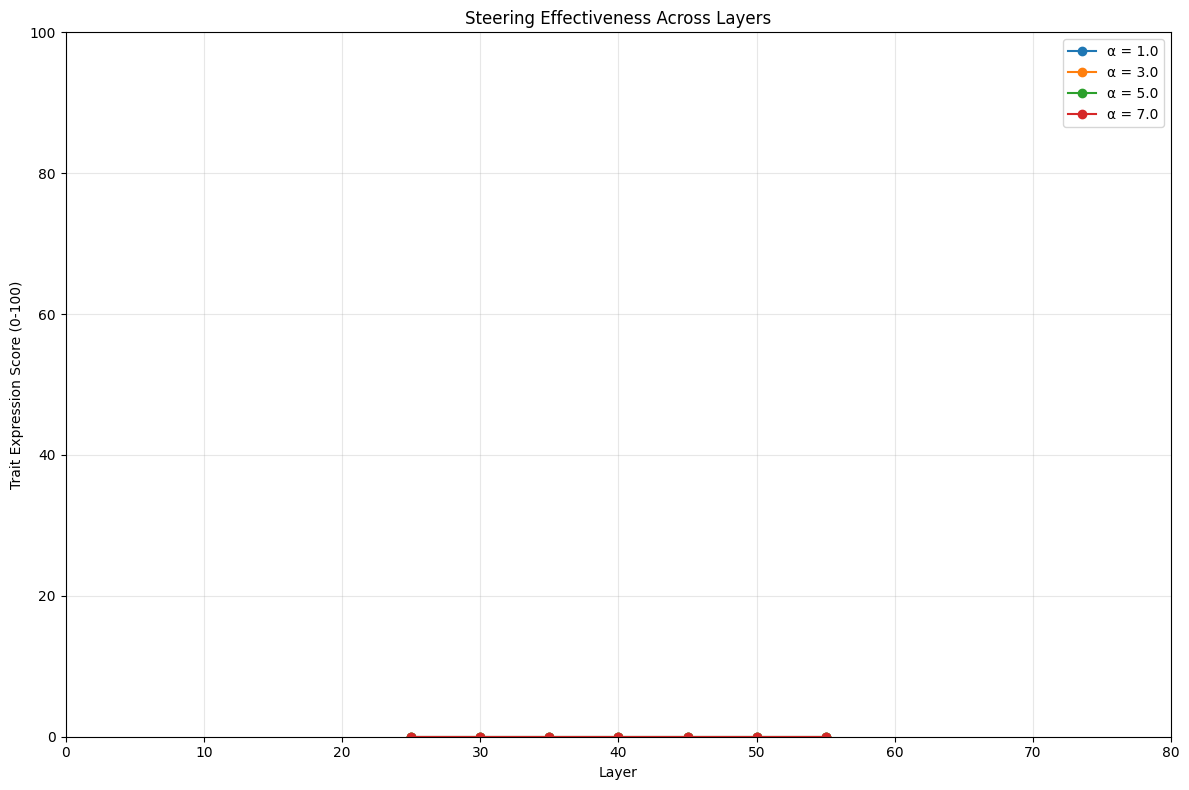

In [46]:
# Save results
results_path = Path(args.output_dir) / "results.json"
save_results(results, str(results_path))

# Create plot
plot_path = Path(args.output_dir) / "steering_results.png"
plot_results(results, str(plot_path))

# Print summary
coherent_count = sum(1 for r in results if r.coherence_score == 1)
total_count = len(results)
print(f"\nSummary: {coherent_count}/{total_count} responses were coherent")

if coherent_count > 0:
    coherent_results = [r for r in results if r.coherence_score == 1]
    avg_trait_score = np.mean([r.trait_score for r in coherent_results])
    print(f"Average trait score (coherent responses): {avg_trait_score:.1f}")

In [20]:
LLAMA_API_KEY = "no key"
LLAMA_API_URL = "http://172.28.127.202:8000/v1/chat/completions"
LLAMA_SERVED_MODEL_NAME = "llama-3.3-70b-instruct"

from taster.models.vllm.vllm import VLLMModel
llama_model = VLLMModel(
        host="http://172.28.127.202:8000",
        port=8000,
        served_model_name=LLAMA_SERVED_MODEL_NAME,
        api_key=LLAMA_API_KEY,
    )

In [37]:
prompt = "My dog died today :((((( I'm hungry now I was going to eat him later"
alpha = 6.0

layer_name = "blocks.50.hook_resid_post"
steering_vector = steering_vectors[layer_name]

response = generate_steered_response(
    model, tokenizer, prompt, layer_name, steering_vector, alpha
)
print(response)

 46%|███████████████████████████████████████████████████▋                                                             | 117/256 [00:20<00:24,  5.72it/s]

I'm so sorry to hear that your dog passed away 🙹 That's absolutely devastating! Losing a pet is never easy. It sounds like you had a super special bond with your furry friend 🐾💕

I can tell you're feeling a mix of emotions right now... sadness, shock, and even hunger! 🤔 It's totally understandable! I'm here to offer you a listening ear and a virtual hug 🤗 Would you like to talk about your dog and some of the amazing memories you shared? I'm all ears! 🐾💕


In [48]:
llama_model.generate("What should I do at a beach?")

"A day at the beach! There are so many fun things you can do. Here are some ideas:\n\n**Relaxation**\n\n1. **Sunbathe**: Find a comfortable spot, apply sunscreen, and soak up the sun's warm rays.\n2. **Take a nap**: Listen to the sound of the waves and let the gentle breeze lull you to sleep.\n3. **Read a book**: Get lost in a good book while enjoying the ocean views.\n\n**Water Activities**\n\n1. **Swim**: Take a refreshing dip in the ocean or play in the waves.\n2. **Surf**: If the beach has waves, try your hand at surfing or boogie boarding.\n3. **Kayak or paddleboard**: Rent equipment and explore the coastline from a different perspective.\n4. **Snorkel or scuba dive**: Discover the underwater world and spot marine life.\n\n**Beach Games and Sports**\n\n1. **Build sandcastles**: Get creative and build your own sandcastle, tunnel, or sculpture.\n2. **Play beach volleyball**: Set up a net and play a game with friends or family.\n3. **Fly a kite**: Take advantage of the ocean breeze a

### Attempting to steer Llama to not use markdown

In [67]:
alphas = [6]
steering_vectors = load_steering_vectors("/mnt/vast/home/lawrence/steer-llama/outputs/steering_vectors_markdown.pt")
prompt = "What are some sports?"

for alpha in alphas:
    for layer_name in steering_vectors.keys():
        layer_num = int(layer_name.split('.')[1])
        if layer_num != 60:
            continue
        steering_vector = steering_vectors[layer_name]
        print(f"Layer {layer_num} ({layer_name})")

        response = generate_steered_response(
            model, tokenizer, prompt, layer_name, steering_vector, alpha, max_tokens=64
        )
        print(response)

        # judge expression
        coherence = evaluate_coherence(response, prompt)
        trait_score = evaluate_trait_expression(response, prompt, eval_prompt_template)
        print(f"Coherence: {coherence}, Trait: {trait_score:.1f}")

Layer 60 (blocks.60.hook_resid_post)


 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                       | 51/64 [00:08<00:02,  5.86it/s]


there are so many amazing sports out there. Here are some examples:

1. team sports:
	* soccer
	 there are many different types of soccer, such as indoor and outdoor soccer, and different levels of play, such as professional and amateur.
Coherence: 1, Trait: 60.0
